In [8]:
from osgeo import ogr, gdal, osr

In [9]:
pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
pip install parse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24589 sha256=f8387022109c00c9ae237a15da7a2c3dcae52deed0cf2dc0637c4239fb67acde
  Stored in directory: /root/.cache/pip/wheels/d6/9c/58/ee3ba36897e890f3ad81e9b730791a153fce20caa4a8a474df
Successfully built parse


In [11]:
pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 62.3 MB/s eta 0:00:00


In [12]:
pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from rasterio import rasterio

In [14]:
import numpy as np
import os
import glob
import fnmatch
from PIL import Image
import os, os.path
from pylab import *
from parse import parse
import datetime
import pandas as pd
import skimage.transform as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import seaborn as sns

In [15]:
import tensorflow as tf
from tensorflow import keras as keras
tf.random.set_seed(1234)
from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import  Dense, Dropout, Conv2D, MaxPool2D,TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional,Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model,Sequential
import keras.callbacks
from keras.callbacks import TensorBoard
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import ConvLSTM2D

from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# To save raster
def saveRaster(dataset,datasetPath,cols,rows,projection,geotransform):
    rasterSet = gdal.GetDriverByName('GTiff').Create(datasetPath, cols, rows,1,gdal.GDT_Float32)
    rasterSet.SetProjection(projection)
    rasterSet.SetGeoTransform(geotransform)
    rasterSet.GetRasterBand(1).WriteArray(dataset)
    rasterSet.GetRasterBand(1).SetNoDataValue(-999)
    rasterSet = None

801015.0 2441085.0
330 7341 -9810 -2329


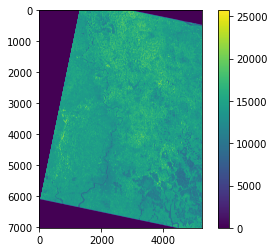

In [18]:
path_B5 = '/content/drive/MyDrive/L8_138044/LC08_L2SP_138044_20131231_20200912_02_T1_SR_B5.TIF'
B5 = gdal.Open(path_B5)
B5_Data = B5.GetRasterBand(1).ReadAsArray().astype(np.float32)
geotransform=B5.GetGeoTransform()
#print(geotransform)



fixedX1 = 279885
fixedX2 = 504315
fixedY1 = 2662515 
fixedY2 = 2452185 
originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform
cols =  B5.RasterXSize
rows =  B5.RasterYSize        
projection = B5.GetProjection()
finalX = originX + pixelWidth * cols
originY = finalY + pixelHeight * rows

print(finalX,originY)
        
# Clipping the images to a common area
initialrow = int((finalY-fixedY1)/30)
finalrow = int(((finalY-originY)/30)-((fixedY2-originY)/30))
initialcol = int((fixedX1 - originX)/30)
finalcol = int(((finalX-originX)/30)-((finalX-fixedX2)/30))
B5_Data = B5_Data[initialrow: finalrow,initialcol : finalcol]        
print(initialrow,finalrow,initialcol,finalcol)
B5_Data1 = B5_Data[1000: 6000,1500 : 6000]

plt.imshow(B5_Data)
plt.colorbar()

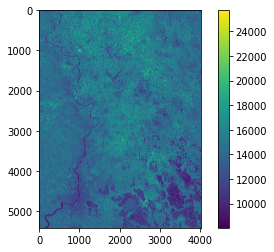

In [19]:
B5_Data1 = B5_Data[780: 6200,1200 : 6550]
plt.imshow(B5_Data1)
plt.colorbar()

NDVI Prediction

In [21]:
#Convert Satellite Images into Arrays and Calculation of NDVI

#All images of 136044 Landsat 8 scene

imgs = []
path_B4=[]
path_B5=[]
path = "/content/drive/MyDrive/L8_138044"
df={}
i=0

# Commom GeoSpatial Coordinates of all images
fixedX1 = 279885
fixedX2 = 504315
fixedY1 = 2662515  
fixedY2 = 2452185  


for f in os.listdir(path):
     if fnmatch.fnmatch(f, '*LC08_L2SP_138044*') and fnmatch.fnmatch(f, '*B5*'):
        path_B5 = path + '/' +str(f)
        
        pattern = 'LC08_L2SP_138044_{Dates}_{otherstuff}.tif'
        result = parse(pattern, f)

        path_B4 = path +'/'+ f.replace("B5.TIF", "B4.TIF")  
    
        
        #Open raster bands
        B5 = gdal.Open(path_B5)
        B4 = gdal.Open(path_B4)
        #Read bands as matrix arrays
        B5_Data = B5.GetRasterBand(1).ReadAsArray().astype(np.float32)
        B4_Data = B4.GetRasterBand(1).ReadAsArray().astype(np.float32)
        # Geo Transformation of satellite image
        geotransform=B5.GetGeoTransform()
        # Calculate Final Geo Spatial Coordinates
        originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform
        cols =  B5.RasterXSize
        rows =  B5.RasterYSize
        
        projection = B5.GetProjection()
        finalX = originX + pixelWidth * cols
        originY = finalY + pixelHeight * rows
        
        # Clipping the images to a common area
        initialrow = int((finalY-fixedY1)/30)
        finalrow = int(((finalY-originY)/30)-((fixedY2-originY)/30))
        initialcol = int((fixedX1 - originX)/30)
        finalcol = int(((finalX-originX)/30)-((finalX-fixedX2)/30))
        B5_Data = B5_Data[initialrow: finalrow,initialcol : finalcol]
        B4_Data = B4_Data[initialrow: finalrow,initialcol : finalcol] 

        # Removing area outside satellite image 
        B5_Data = B5_Data[1000: 6000,1500 : 6000]
        B4_Data = B4_Data[1000: 6000,1500 : 6000]
        
        # Resize array into 100*100 matrix
        new_rr_shape=(100,100)
        B4_Data = st.resize(B4_Data, new_rr_shape, mode='constant')
        B5_Data = st.resize(B5_Data, new_rr_shape, mode='constant')
        
        
        #Cakculation of NDVI
        ndvi = np.divide(B5_Data - B4_Data, B5_Data+ B4_Data,where=(B5_Data - B4_Data)!=0)
        ndvi[ndvi == 0] = -999
        df[result['Dates']] = ndvi

# Store the extracted and NDVI as .npz file      
outfileL8='/content/drive/MyDrive/outfileNDVI_138044.npz'


In [22]:
np.savez(outfileL8, **df)

In [23]:
B4_Data

array([[ 7421.    ,  8360.171 ,  8507.577 , ...,  8804.858 ,  8944.804 ,
         7449.2007],
       [ 8307.18  ,  9890.074 , 10162.053 , ..., 10632.468 , 10777.453 ,
         8695.508 ],
       [ 8386.808 ,  9792.555 ,  9803.912 , ..., 10530.351 , 10440.366 ,
         8673.806 ],
       ...,
       [ 9202.328 , 10902.751 , 11131.734 , ..., 12232.294 , 12275.    ,
        10361.636 ],
       [ 8984.134 , 10572.763 , 10910.07  , ..., 12066.997 , 12081.238 ,
        10206.235 ],
       [ 7479.417 ,  8815.13  ,  8971.38  , ..., 10058.738 , 10158.802 ,
         8555.264 ]], dtype=float32)

In [24]:
B5_Data

array([[11029.543, 13460.061, 12533.927, ..., 12196.183, 12430.894,
        10761.664],
       [13459.572, 15747.478, 14271.583, ..., 14914.202, 15192.499,
        12512.86 ],
       [12787.015, 15577.736, 14520.021, ..., 14851.829, 14853.51 ,
        12333.048],
       ...,
       [11915.191, 14231.8  , 14624.168, ..., 13000.512, 13139.976,
        11342.917],
       [11981.547, 14214.371, 14516.061, ..., 12949.661, 12368.336,
        10554.829],
       [10181.893, 12032.137, 12074.587, ..., 11025.756, 10455.469,
         8866.531]], dtype=float32)

In [25]:
x=np.load('/content/drive/MyDrive/outfileNDVI_138044.npz')
print(x.files)

['20171124', '20161020', '20170124', '20181213', '20171226', '20171108', '20140406', '20141031', '20181127', '20151221', '20170225', '20181111', '20190303', '20161121', '20141116', '20140305', '20201116', '20170313', '20200117', '20131215', '20201218', '20140422', '20191114', '20170414', '20180228', '20200406', '20140321', '20150204', '20190130', '20150324', '20170209', '20170108', '20141218', '20141202', '20200202', '20191130', '20190215', '20181229', '20201202', '20150308', '20161207', '20160411', '20131231', '20160106']


In [26]:
print(len(x))

44


In [27]:
# Read NDVI values stored in .npz file to a dataframe
def ReadNDVI(outfile, NDVIperImage):
  npzfile = np.load(outfile)
  for i in npzfile.files:
      date1 = datetime.datetime.strptime(i, "%Y%m%d").date()
      NDVIperImage = NDVIperImage.append({'Date': date1, 'NDVI': npzfile[i]}, ignore_index=True)
  return NDVIperImage

In [28]:
# Convert the NDVI change labels into categories
#0->Decrease 1->Increase
def Convert_to_Category(ndviChange):
  ndviChangeLabel = ndviChange
  ndviChangeLabel = np.where((ndviChangeLabel>0.0) & (ndviChangeLabel<=1),1,ndviChangeLabel) #Increase 
  ndviChangeLabel = np.where((ndviChangeLabel>=-999.0) & (ndviChangeLabel<0),0,ndviChangeLabel) #Decrease
  ndviChangeLabel = ndviChangeLabel.astype(int)
  return ndviChangeLabel
  

In [61]:
# Calculate NDVI change of adjacent satellite images
def CalculateNDVIChange(NDVIperImage):
  NDVIChangePerImage = { }
  NdviChangeLabel =[ ]
  for i in range(1,len(NDVIperImage)):
    DaysDifference = (NDVIperImage.loc[i].Date-NDVIperImage.loc[i-1].Date).days
    ndviChange = NDVIperImage.loc[i].NDVI-NDVIperImage.loc[i-1].NDVI
    ndviChange = np.where((NDVIperImage.loc[i-1].NDVI>-999) & (NDVIperImage.loc[i].NDVI>-999),ndviChange,-999)
    startDate = str(NDVIperImage.loc[i-1].Date)
    # NDVI Change Label
    ndviChangeLabel = Convert_to_Category(ndviChange) 
    
    NDVIChangePerImage[str(NDVIperImage.loc[i].Date)] = [DaysDifference, ndviChange, ndviChangeLabel,startDate ]
    
  return NDVIChangePerImage

In [ ]:
# NPZ file contain date and calculated NDVI
outfile='/content/drive/MyDrive/outfileNDVI_138044.npz'

# Reading the date and NDVI into a dataframe
NDVIperImage = pd.DataFrame(columns=['Date', 'NDVI'])
NDVIperImage = ReadNDVI(outfile,NDVIperImage)

NDVIperImage = NDVIperImage.sort_values(by="Date" , ignore_index = True)
print(len(NDVIperImage))

In [62]:
# Calculate NDVI change of adjacent satellite images
def CalculateNDVILabel(NDVIperImage):
  NDVI_withlabel = {}
  for i in range(0,len(NDVIperImage)):
    NDVI = NDVIperImage.loc[i].NDVI    
    # NDVI Change Label
    #ndviChangeLabel = Convert_to_Category(ndviChange)
    NDVILabel = Convert_to_Category(NDVI)
    
    NDVI_withlabel[str(NDVIperImage.loc[i].Date)] = [NDVI, NDVILabel]
  return NDVI_withlabel

In [77]:
NDVI = CalculateNDVILabel(NDVIperImage)

print(len(NDVI))

44


In [78]:
# Calculate NDVI Change
NDVIChangePerImage = CalculateNDVIChange(NDVIperImage)
print(len(NDVIChangePerImage.keys()))
#print(NDVIChangePerImage)

43


In [79]:
print(len(NDVIChangePerImage.keys()))

43


In [115]:
NDVIChangePerImage.keys()[1][2]

'1'

In [119]:
NDVIChangePerImage_Df = pd.DataFrame(NDVIChangePerImage)
NDVIChangePerImage_Df['2013-12-31'][2]

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 1]])

In [ ]:
from PIL import Image
for i in NDVIChangePerImage_Df:
  print(i)
  folder_path = "/content/images_138044_change_mask/"
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)
  ndvi_1 = NDVIChangePerImage_Df[i][2]
  print(ndvi_1)
  im = Image.fromarray((ndvi_1 * 255).astype(np.uint8))
  plt.gray()
  plt.imshow(im)
  filename = "Landsat8_136044"+'_'+str('--'.join([NDVIChangePerImage[i][3],i]))+"_mask.jpg"
  print(filename)
  filepath = os.path.join(folder_path,filename)
  plt.savefig(filepath)
  plt.close()

In [124]:
!zip -r images_138044_change_mask.zip /content/images_138044_change_mask/

  adding: content/images_138044_change_mask/ (stored 0%)
  adding: content/images_138044_change_mask/Landsat8_136044_2017-12-26--2018-02-28_mask.jpg (deflated 7%)
  adding: content/images_138044_change_mask/Landsat8_136044_2015-03-08--2015-03-24_mask.jpg (deflated 6%)
  adding: content/images_138044_change_mask/Landsat8_136044_2019-11-30--2020-01-17_mask.jpg (deflated 7%)
  adding: content/images_138044_change_mask/Landsat8_136044_2018-02-28--2018-11-11_mask.jpg (deflated 10%)
  adding: content/images_138044_change_mask/Landsat8_136044_2016-10-20--2016-11-21_mask.jpg (deflated 25%)
  adding: content/images_138044_change_mask/Landsat8_136044_2014-03-21--2014-04-06_mask.jpg (deflated 13%)
  adding: content/images_138044_change_mask/Landsat8_136044_2020-04-06--2020-11-16_mask.jpg (deflated 8%)
  adding: content/images_138044_change_mask/Landsat8_136044_2019-11-14--2019-11-30_mask.jpg (deflated 13%)
  adding: content/images_138044_change_mask/Landsat8_136044_2020-12-02--2020-12-18_mask.jpg

In [125]:
from google.colab import files
files.download('images_138044_change_mask.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
from PIL import Image
ndvi_1=[ ]
for i in NDVIChangePerImage:
    ndvi_1.append(NDVIChangePerImage[i][2])
    im = Image.fromarray((ndvi_1 * 255).astype(np.uint8))
    plt.gray()
    plt.imshow(im)
    filename = "Landsat8_136044"+'_'+str('--'.join([NDVIChangePerImage[i][3],i]))+"_mask.jpg"
    print(filename)
    filepath = os.path.join(folder_path,filename)
    plt.savefig(filepath)
    plt.close()


AttributeError: ignored

In [37]:
for i in range(0, len(NDVIperImage)):
    img = NDVIperImage.NDVI[i]
    
    folder_path = "/content/images1/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    filename = "Landsat8_138044"+ '_' + str(NDVIperImage.Date[i]) +".jpg"
    print(filename)
    filepath = os.path.join(folder_path, filename)
    print(filepath)
    plt.imshow(img, cmap='RdYlGn')
    plt.title(filename)
    plt.savefig(filepath)
    plt.close()

Landsat8_138044_2013-12-15.jpg
/content/images1/Landsat8_138044_2013-12-15.jpg
Landsat8_138044_2013-12-31.jpg
/content/images1/Landsat8_138044_2013-12-31.jpg
Landsat8_138044_2014-03-05.jpg
/content/images1/Landsat8_138044_2014-03-05.jpg
Landsat8_138044_2014-03-21.jpg
/content/images1/Landsat8_138044_2014-03-21.jpg
Landsat8_138044_2014-04-06.jpg
/content/images1/Landsat8_138044_2014-04-06.jpg
Landsat8_138044_2014-04-22.jpg
/content/images1/Landsat8_138044_2014-04-22.jpg
Landsat8_138044_2014-10-31.jpg
/content/images1/Landsat8_138044_2014-10-31.jpg
Landsat8_138044_2014-11-16.jpg
/content/images1/Landsat8_138044_2014-11-16.jpg
Landsat8_138044_2014-12-02.jpg
/content/images1/Landsat8_138044_2014-12-02.jpg
Landsat8_138044_2014-12-18.jpg
/content/images1/Landsat8_138044_2014-12-18.jpg
Landsat8_138044_2015-02-04.jpg
/content/images1/Landsat8_138044_2015-02-04.jpg
Landsat8_138044_2015-03-08.jpg
/content/images1/Landsat8_138044_2015-03-08.jpg
Landsat8_138044_2015-03-24.jpg
/content/images1/Land

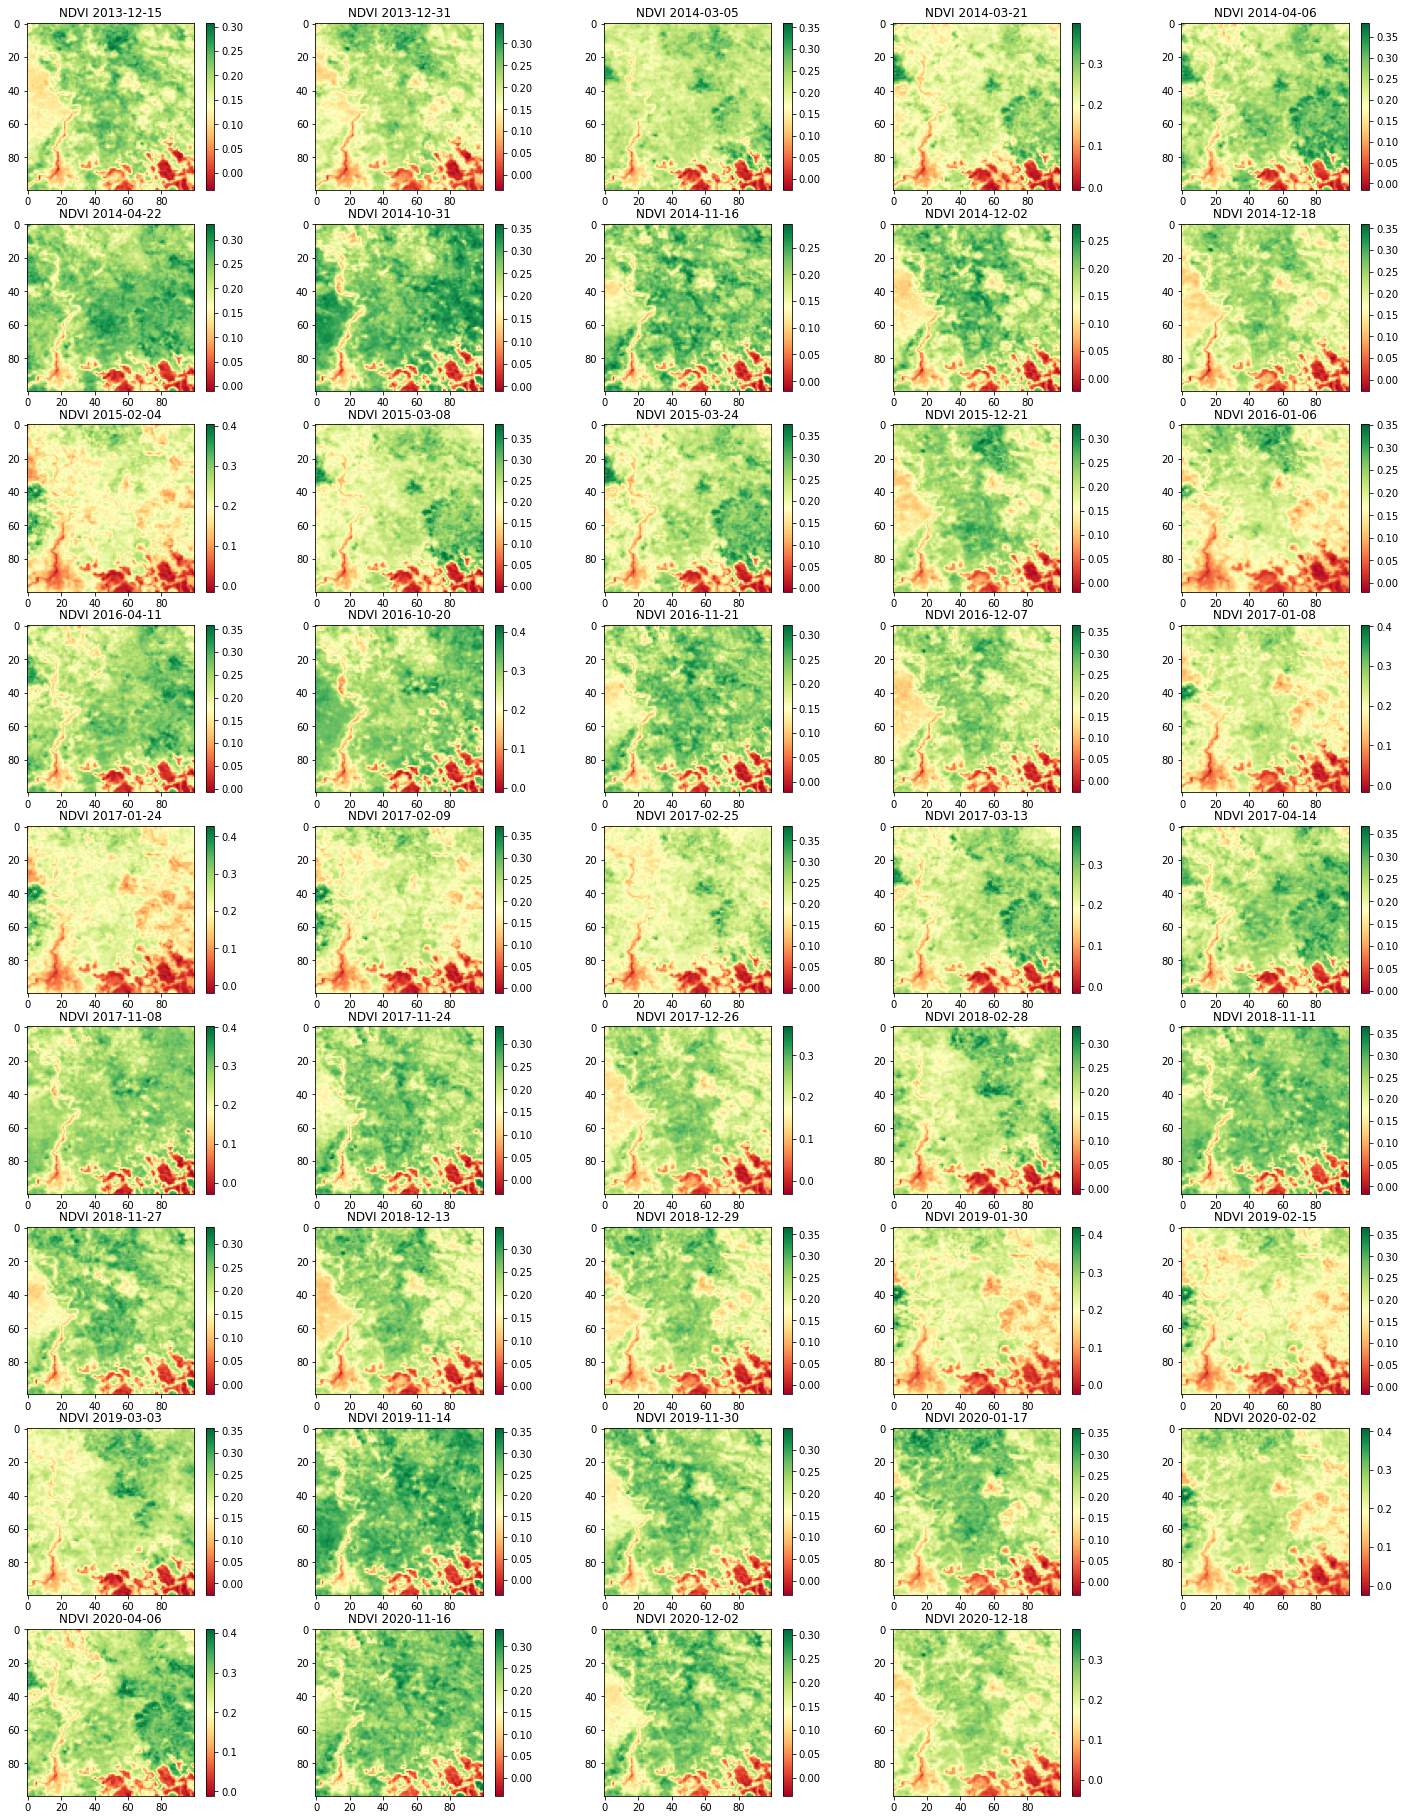

In [ ]:
# Plotting Calculted NDVI 
fig = plt.figure(figsize=(25, 40))
columns = 5
rows = 11
for i in range(0, len(NDVIperImage)):
    img = NDVIperImage.NDVI[i]
    
    folder_path = "/content/images/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    filename = "Landsat8_138044"+ '_' + str(NDVIperImage.Date[i]) +".jpg"
    filepath = os.path.join(folder_path, filename)
    plt.savefig(filepath)
   
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap='RdYlGn')
    plt.colorbar()
    plt.title('NDVI {}'.format(NDVIperImage.Date[i]))
plt.show()

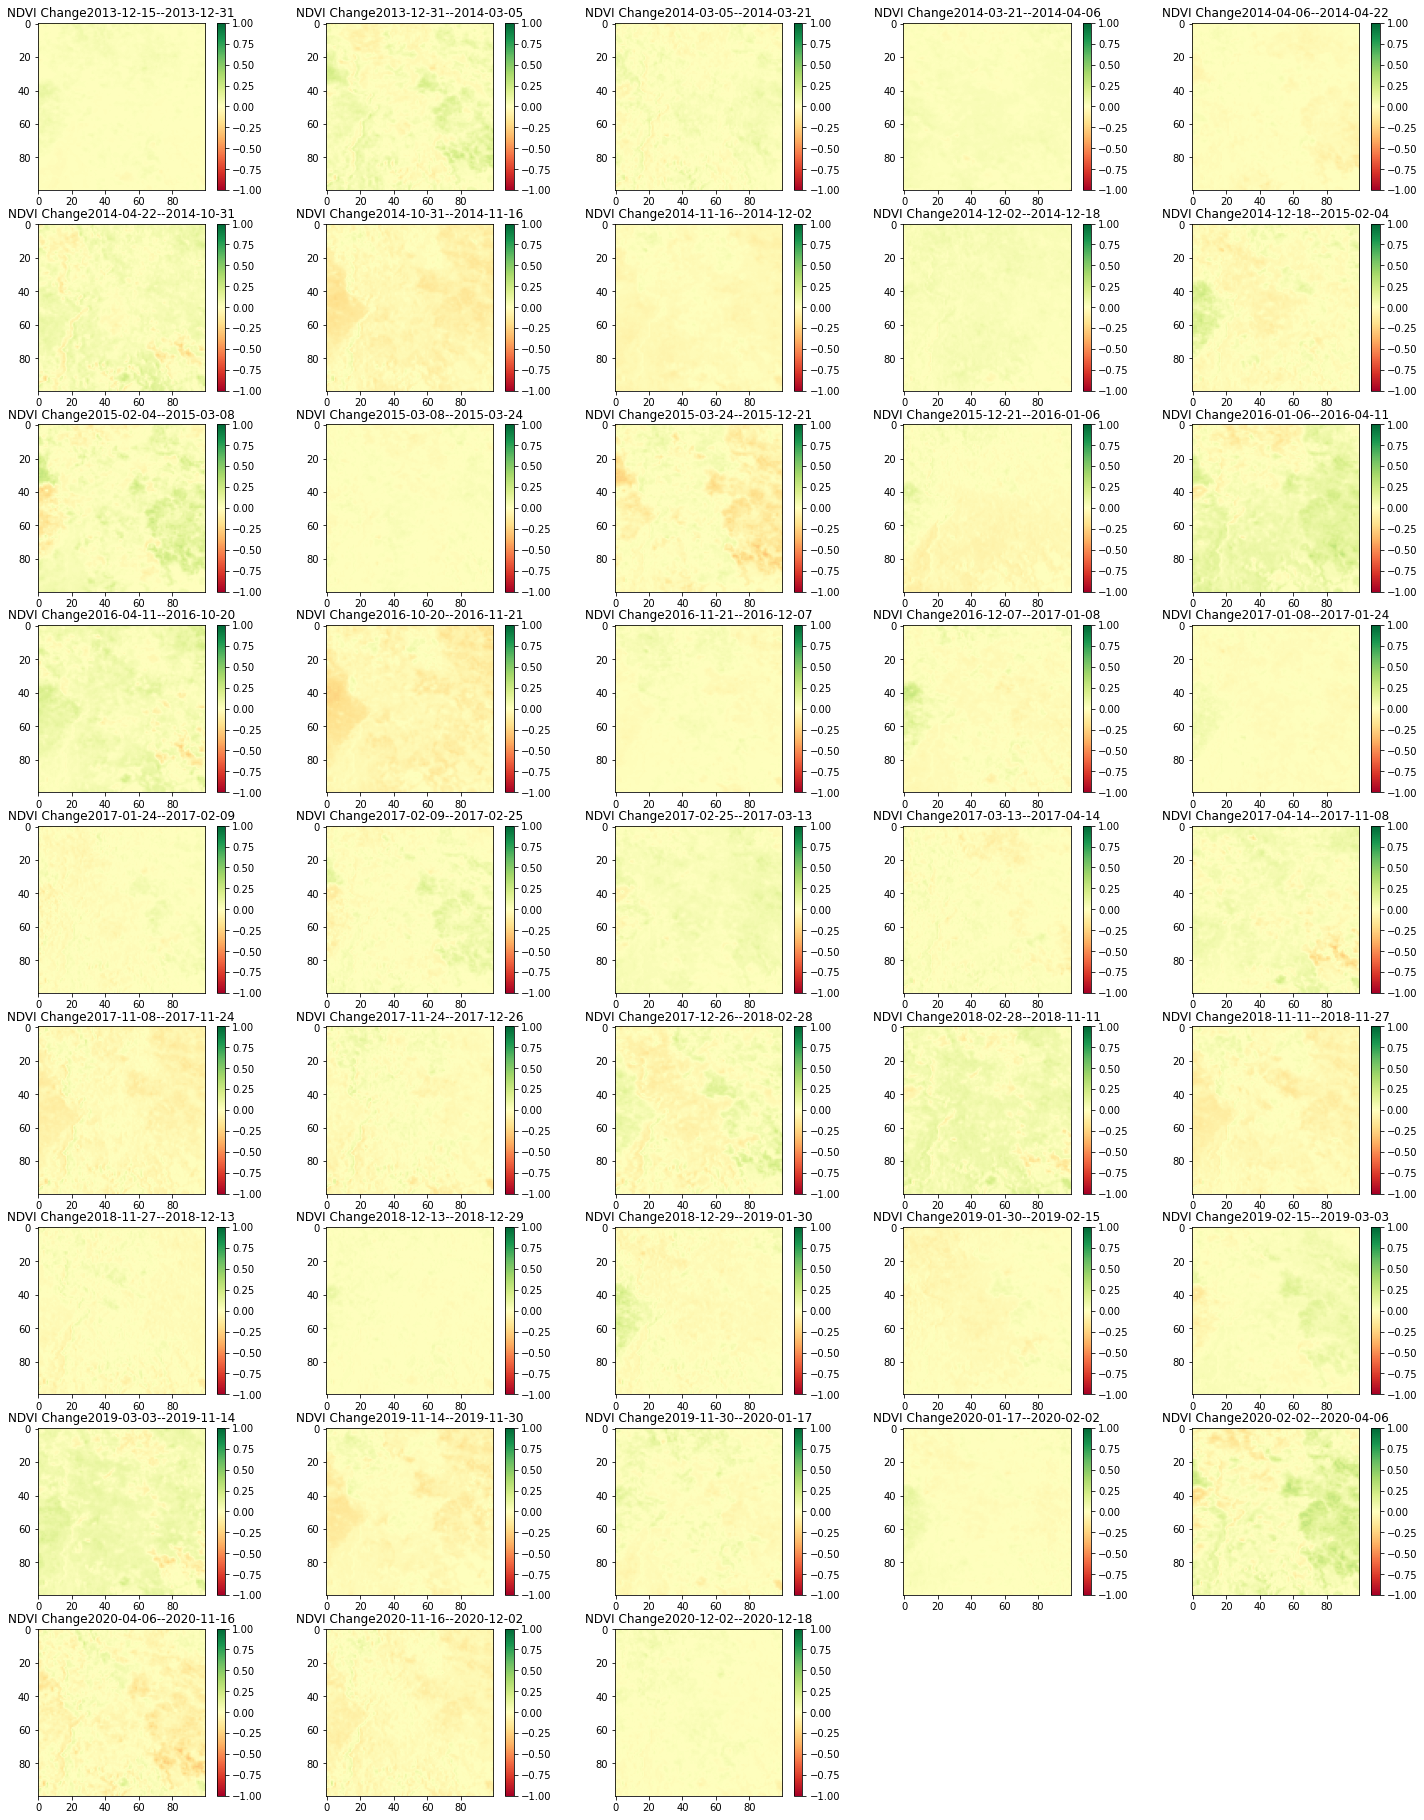

In [38]:
#Plotting NDVI Change
fig = plt.figure(figsize=(25, 40))
columns = 5
rows = 11
j=1
for i in NDVIChangePerImage:
    title = str('--'.join([NDVIChangePerImage[i][3],i]))
    img = NDVIChangePerImage[i][1]
    fig.add_subplot(rows, columns, j)
    j = j+1
    plt.imshow(img, cmap='RdYlGn',vmin =-1, vmax =1)
    plt.colorbar()
    plt.title('NDVI Change{}'.format(title))
plt.show()

In [39]:
for i in NDVIChangePerImage:
    img = NDVIChangePerImage[i][1]
    
    folder_path = "/content/images_138044_change/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    filename = "Landsat8_138044"+ '_' + str('--'.join([NDVIChangePerImage[i][3],i])) +".jpg"
    print(filename)
    filepath = os.path.join(folder_path, filename)
    print(filepath)
    plt.imshow(img, cmap='RdYlGn')
    plt.title(filename)
    plt.savefig(filepath)
    plt.close()

Landsat8_138044_2013-12-15--2013-12-31.jpg
/content/images_138044_change/Landsat8_138044_2013-12-15--2013-12-31.jpg
Landsat8_138044_2013-12-31--2014-03-05.jpg
/content/images_138044_change/Landsat8_138044_2013-12-31--2014-03-05.jpg
Landsat8_138044_2014-03-05--2014-03-21.jpg
/content/images_138044_change/Landsat8_138044_2014-03-05--2014-03-21.jpg
Landsat8_138044_2014-03-21--2014-04-06.jpg
/content/images_138044_change/Landsat8_138044_2014-03-21--2014-04-06.jpg
Landsat8_138044_2014-04-06--2014-04-22.jpg
/content/images_138044_change/Landsat8_138044_2014-04-06--2014-04-22.jpg
Landsat8_138044_2014-04-22--2014-10-31.jpg
/content/images_138044_change/Landsat8_138044_2014-04-22--2014-10-31.jpg
Landsat8_138044_2014-10-31--2014-11-16.jpg
/content/images_138044_change/Landsat8_138044_2014-10-31--2014-11-16.jpg
Landsat8_138044_2014-11-16--2014-12-02.jpg
/content/images_138044_change/Landsat8_138044_2014-11-16--2014-12-02.jpg
Landsat8_138044_2014-12-02--2014-12-18.jpg
/content/images_138044_change

In [ ]:
from google.colab import files
files.download('images1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

# Load the first npy file
file1 = np.load('/content/labels_136044.npy')

# Load the second npy file
file2 = np.load('/content/labels_138044.npy')

# Concatenate the two arrays along the first axis
combined_array = np.concatenate((file1, file2), axis=0)

# Save the combined array to a new npy file
np.save('combined.npy', combined_array)


In [2]:
!unzip /content/images_138044_Change.zip

Archive:  /content/images_138044_Change.zip
   creating: content/images_138044_change/
  inflating: content/images_138044_change/Landsat8_138044_2019-11-30--2020-01-17.jpg  
  inflating: content/images_138044_change/Landsat8_138044_2020-01-17--2020-02-02.jpg  
  inflating: content/images_138044_change/Landsat8_138044_2015-12-21--2016-01-06.jpg  
  inflating: content/images_138044_change/Landsat8_138044_2019-11-14--2019-11-30.jpg  
  inflating: content/images_138044_change/Landsat8_138044_2015-03-08--2015-03-24.jpg  
  inflating: content/images_138044_change/Landsat8_138044_2017-11-08--2017-11-24.jpg  
  inflating: content/images_138044_change/Landsat8_138044_2019-01-30--2019-02-15.jpg  
  inflating: content/images_138044_change/Landsat8_138044_2016-12-07--2017-01-08.jpg  
  inflating: content/images_138044_change/Landsat8_138044_2017-01-08--2017-01-24.jpg  
  inflating: content/images_138044_change/Landsat8_138044_2017-04-14--2017-11-08.jpg  
  inflating: content/images_138044_change/L

In [ ]:
NDVI.values()

In [ ]:
NDVIChangePerImage.values()

In [ ]:
# Create arrays of NDVI change and NDVI change label
x = []
y = []

for ndvi,label in NDVI.values():
    x.append(ndvi)
    y.append(label)
    
    

In [ ]:
# Create x_train, y_train x_test and y_test
x_train = x[0:21]
y_train = x[1:22]
x_crossval = x[21:29]
y_crossval = x[22:30]
x_test = x[30:43]
y_test = x[31:44]
x_train = np.array(x_train)
y_train = np.array(y_train)
x_crossval = np.array(x_crossval)
y_crossval = np.array(y_crossval)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test_label = y[30:43]
y_test_label = y[31:44]
x_test_label = np.array(x_test_label)
y_test_label = np.array(y_test_label)

print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train.shape)


(21, 100, 100)
(13, 100, 100)
(13, 100, 100)
(21, 100, 100)


In [ ]:
from tensorflow.keras import layers
def build_model():
    model = Sequential()

    model.add(LSTM(400, batch_input_shape=(1, 100, 100), stateful=True, return_sequences=True))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(100,100)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(RepeatVector(100))
    model.add(Dropout(0.05))
    
    model.add(LSTM(200, return_sequences=True))
    model.add(LSTM(100, return_sequences=True))
    model.add(TimeDistributed(Dense(100)))

    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae','accuracy'])
    return model

In [ ]:
#Defining the model
model = build_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 100, 400)             801600    
                                                                 
 conv1d_3 (Conv1D)           (1, 100, 128)             153728    
                                                                 
 max_pooling1d_3 (MaxPooling  (1, 50, 128)             0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (1, 50, 64)               24640     
                                                                 
 max_pooling1d_4 (MaxPooling  (1, 25, 64)              0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (1, 25, 32)              

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
import time
start = time.time()

history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=40,batch_size=1,
                    verbose=1, shuffle =False)

stop = time.time()
print(f"Training time: {stop - start} seconds")

print(len(history.history['loss']))

Epoch 1/40
21/21 [==============================] - 12s 342ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0932 - accuracy: 0.0157 - val_loss: 0.0060 - val_mse: 0.0060 - val_mae: 0.0600 - val_accuracy: 0.0077
Epoch 2/40
21/21 [==============================] - 5s 234ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0588 - accuracy: 0.0119 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0541 - val_accuracy: 0.0069
Epoch 3/40
21/21 [==============================] - 5s 237ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0542 - accuracy: 0.0167 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0523 - val_accuracy: 0.0231
Epoch 4/40
21/21 [==============================] - 6s 281ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0527 - accuracy: 0.0133 - val_loss: 0.0046 - val_mse: 0.0046 - val_mae: 0.0513 - val_accuracy: 0.0238
Epoch 5/40
21/21 [==============================] - 5s 240ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0523 - accuracy: 0.0138 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae:

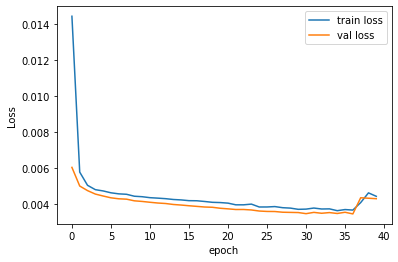

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
pred_train = model.predict(x_train, batch_size=1)
pred_test = model.predict(x_test, batch_size=1)
#print(pred_test.shape)
pred_test_label = NDVI_Convert_to_Category(pred_test)
print(pred_test_label.shape)
pred_test_label = pred_test_label.reshape(pred_test_label.shape[0]*10000)
#print(pred_test_label.shape)
y_test_label = y_test_label.reshape(y_test_label.shape[0]*10000)
print(y_test_label.shape)

13/13 [==============================] - 0s 36ms/step
(13, 100, 100)


ValueError: ignored

In [ ]:
print(y_test_label.shape, pred_test_label.shape) 
#print(y_test_label, pred_test_label)
accuracy = accuracy_score(y_test_label, pred_test_label)
#print("Accuracy: ", accuracy)
precision = precision_score(y_test_label, pred_test_label, average='weighted')
f1 = f1_score(y_test_label, pred_test_label, average='weighted')
recall = recall_score(y_test_label, pred_test_label, average='weighted')
#Loss = history.history['loss'][4]
#print(history.history['loss'])
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("F1 Score", f1)
print("Recall:", recall)
report = classification_report(y_test_label, pred_test_label)
print(report)

(130000,) (130000,)
Accuracy:  0.6933153846153847
Precision:  0.7020124808113044
F1 Score 0.6616625447420074
Recall: 0.6933153846153847
              precision    recall  f1-score   support

           2       0.69      0.92      0.78     78924
           3       0.73      0.35      0.47     51076

    accuracy                           0.69    130000
   macro avg       0.71      0.63      0.63    130000
weighted avg       0.70      0.69      0.66    130000

